# Load from database

<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fsspec gcsfs

     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 35.1 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 160 kB 66.3 MB/s 


In [119]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [97]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [98]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'sessions.session', 'contenttypes.contenttype', 'auth.user', 'core.prompt', 'core.annotation', 'core.timestamp', 'admin.logentry', 'core.profile', 'core.decodingstrategy', 'core.feedbackoption', 'core.generation', 'auth.permission', 'core.system', 'core.dataset', 'core.playlist'}


### Load all the tables

In [99]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [100]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

In [101]:
generation_df["system"]

0           gpt2
1           gpt2
2           gpt2
3           gpt2
4           gpt2
          ...   
28542    davinci
28543    davinci
28544    davinci
28545    davinci
28546    davinci
Name: system, Length: 28547, dtype: object

### Merge all the relevant tables together.

In [102]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [103]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')

In [104]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

In [105]:
full_df

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,playlist_name,playlist_version
0,2021-06-12 22:17:41.178000+00:00,2,909,1,3,0,False,[],1,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.3
1,2021-06-12 23:08:41.084000+00:00,4,909,1,3,0,False,[contradicts_knowledge],2,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.3
2,2021-06-21 19:31:08.098000+00:00,139,18298,3,0,0,False,[contradicts_knowledge],3,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
3,2021-06-23 19:35:29.878000+00:00,182,18298,3,0,0,False,[-2311780724603632545],4,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
4,2021-06-25 18:56:37.169000+00:00,272,12621,-1,7,0,False,[irrelevant],5,gpt2-xl,7668,4,The Mayor has been in office for more than two...,"USUALLY, when a mayor dismisses people from th...",9,3,1098,top-p,0.2,New York Times,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47006,2021-10-18 20:21:23.674000+00:00,1750,18385,7,3,0,False,[common_sense],51496,ctrl,13432,1,And while it may not be a direct result of Kat...,"""Remarks on Hurricane Katrina Relief Efforts"" ...",6,8,431,top-p,0.4,Presidential Speeches,0.2
47007,2021-10-18 20:21:34.737000+00:00,1750,18147,7,5,1,False,[grammar],51497,ctrl,13194,1,The story today is that in an attempt to cover...,"""Address to the Nation About the Watergate Inv...",2,8,77,top-p,0.4,Presidential Speeches,0.2
47008,2021-10-20 11:43:52.949000+00:00,5819,4051,5,0,0,False,[irrelevant],51498,gpt2,4104,1,There are a few more items that need an explan...,The chains have begun to wear into the flesh o...,7,2,2269,top-p,0.4,Short Stories,0.2
47009,2021-10-22 18:06:57.350000+00:00,5907,3844,5,3,0,False,[common_sense],51499,gpt2,3896,1,He pointed it toward them and watched carefull...,"""These are not for you._SEP_I swear,"" he whisp...",6,2,2008,top-p,0.4,Short Stories,0.2


# Filtering annotations for users who have agreed to have their data analyzed

In [106]:
SURVEY_RESPONSES_FILE = 'gs://roft_buckups/521_responses.csv'
survey_df = pd.read_csv(SURVEY_RESPONSES_FILE)
survey_filter_df = survey_df[survey_df["Do you agree for the data being collected on this form along with any annotations you make on the RoFT website to be used in an anonymized, aggregated way for research on students' ability to detect machine-generated text? Your answer on this question will not affect your grade."] == 'No']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[~user_df.email.isin(survey_filter_df["Email Address"].values)]

# all the profiles that GAVE US PERMISSION
profiles_filter_df = profile_df[profile_df.user.isin(users_filter_df.pk)]

full_df = full_df[full_df.annotator.isin(profiles_filter_df.pk)]

In [ ]:
# TODO: Filter out our own profiles

# Analysis

## Mean points

In [107]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      df = full_df[(full_df["playlist_name"]==playlist) & 
                          (full_df["system"]==model) &
                          (full_df["playlist_version"]=="0.2")]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,model,mean score,median score,fraction_nonzero,num_annotations
0,Recipes,gpt2-xl,2.067023,0.0,0.479583,7102
1,Recipes,finetuned,1.924421,1.0,0.513056,10876
2,Presidential Speeches,ctrl,2.205159,2.0,0.587175,8374
3,Short Stories,davinci,1.842697,1.0,0.629213,89
4,Short Stories,gpt2-xl,1.765329,1.0,0.514383,2642
5,Short Stories,gpt2,2.046058,1.0,0.512889,5276
6,New York Times,easy,2.697248,3.0,0.712538,327
7,New York Times,gpt2-xl,1.817623,1.0,0.511165,7479


In [157]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(generation_df["system"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat"]=="top-p") &
                  (full_df["dec_strat_value"]==top_p_value) &
                  (full_df["playlist_name"]==playlist) &
                  (full_df["system"]==model) &
                          (full_df["playlist_version"]=="0.2")]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean score": np.mean(df["points"]),
                  "median score": np.median(df["points"]),
                  "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

out_df = analyze_per_decoding_strat() 
out_df

,p-value,playlist,model,mean score,median score,fraction_nonzero,num_annotations
0,0.4,Recipes,gpt2-xl,2.067023,0.0,0.479583,7102
1,0.4,Recipes,finetuned,1.924421,1.0,0.513056,10876
2,0.4,Presidential Speeches,ctrl,2.205159,2.0,0.587175,8374
3,0.4,Short Stories,davinci,1.842697,1.0,0.629213,89
4,0.0,Short Stories,gpt2-xl,1.491587,0.0,0.466346,832
5,0.4,Short Stories,gpt2-xl,1.719917,1.0,0.504149,964
6,1.0,Short Stories,gpt2-xl,2.086288,2.0,0.573286,846
7,0.4,Short Stories,gpt2,2.046058,1.0,0.512889,5276
8,0.0,New York Times,gpt2-xl,1.638921,0.0,0.481310,2595
9,0.4,New York Times,gpt2-xl,1.684787,0.0,0.486304,2373


### Comparison of GPT-2 XL across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

Text(0, 0.5, 'Mean Score')

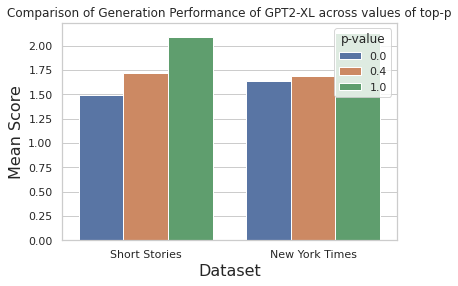

In [158]:
sns.set_theme(style="whitegrid")
p = sns.barplot(x="playlist", y="mean score", hue="p-value", data=out_df[(out_df["model"]=="gpt2-xl") & (out_df["playlist"]=="Short Stories") | (out_df["playlist"]=="New York Times")])
p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

Text(0, 0.5, 'Mean Score')

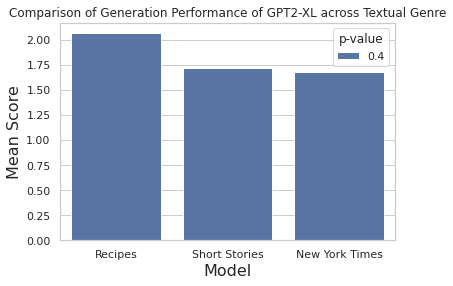

In [111]:
p = sns.barplot(x="playlist", y="mean score", hue="p-value", data=out_df[(out_df["model"]=="gpt2-xl") & (out_df["p-value"]==0.4)])
p.set_title("Comparison of Generation Performance of GPT2-XL across Textual Genre")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

Text(0, 0.5, 'Mean Score')

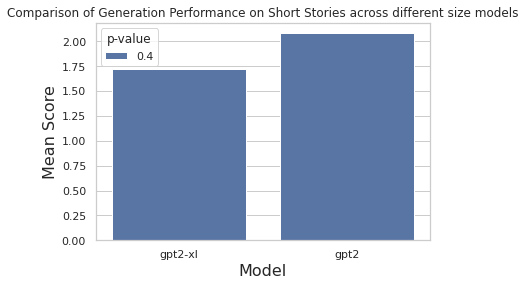

In [154]:
p = sns.barplot(x="model", y="mean score", hue="p-value", data=out_df[(out_df["playlist"]=="Short Stories") & (out_df["p-value"]==0.4) & (out_df["model"]!="davinci")])
p.set_title("Comparison of Generation Performance on Short Stories across different size models")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

### Comparison of fine-tuning performance

Text(0, 0.5, 'Mean Score')

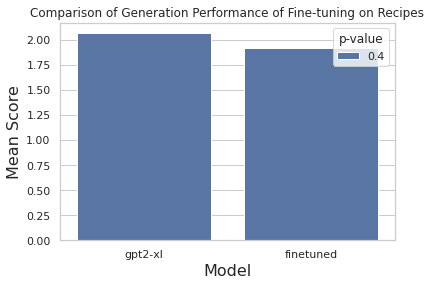

In [159]:
p = sns.barplot(x="model", y="mean score", hue="p-value", data=out_df[(out_df["playlist"]=="Recipes")])
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

#Mean Points for only the first 10 annotations from each annotator


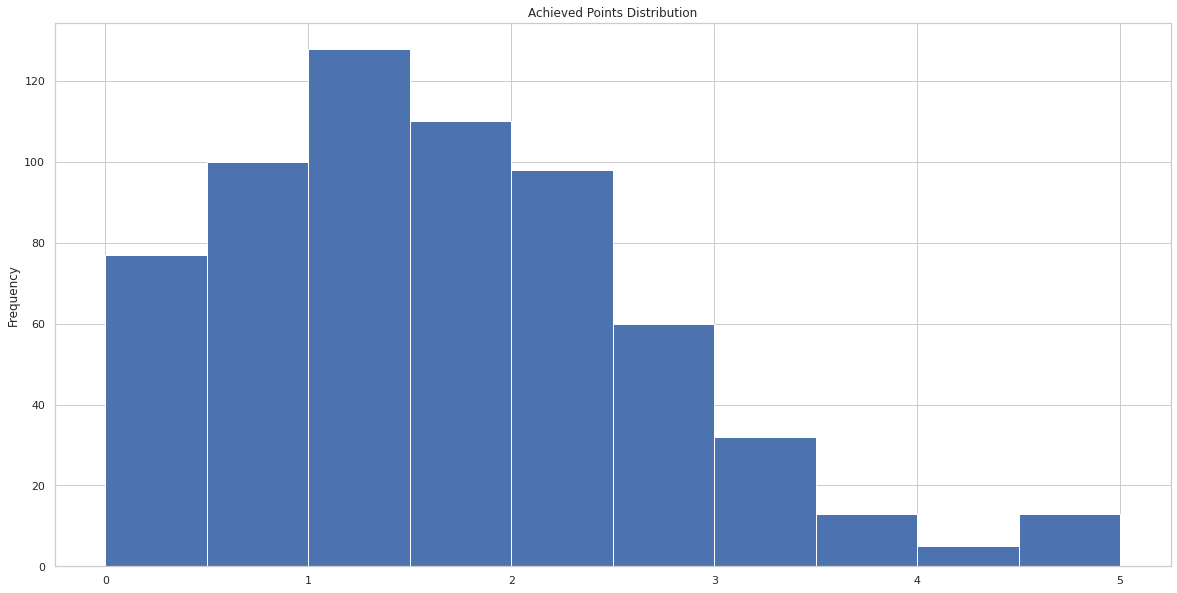

In [114]:
full_df.sort_values(['date']).groupby('annotator').head(10).groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

## Annotator skill

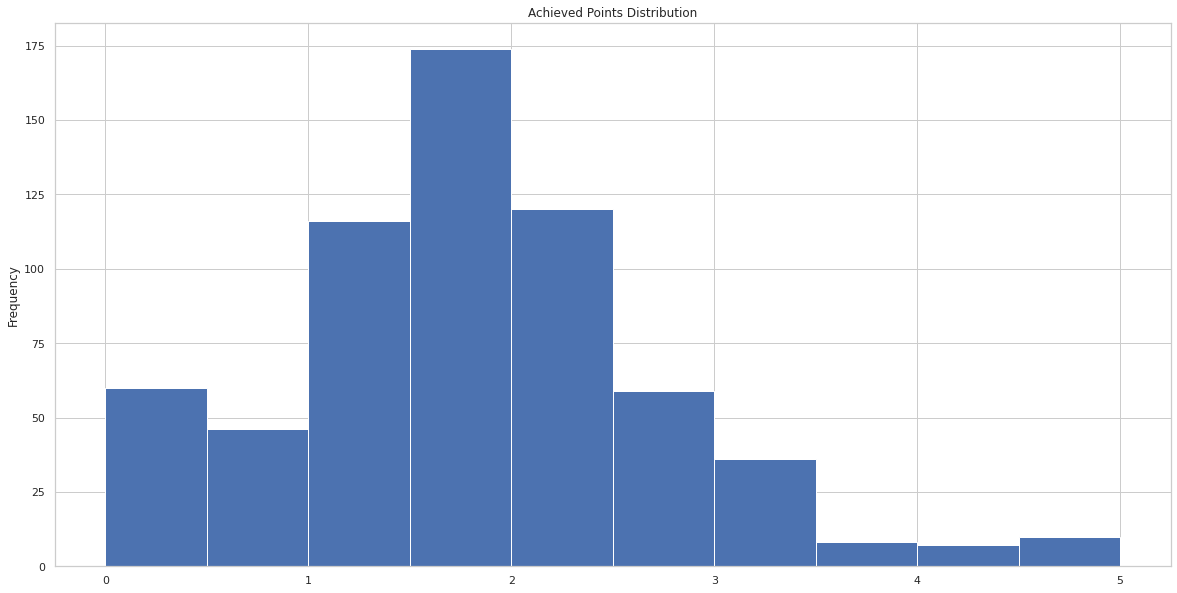

In [115]:
full_df.groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

Of the annotators who did at least K annotations, plot their mean score over time

In [147]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

20
SpearmanrResult(correlation=-0.028290224523560413, pvalue=0.7799368076408045)
(-0.001985586177818326, 0.9843574853497475)


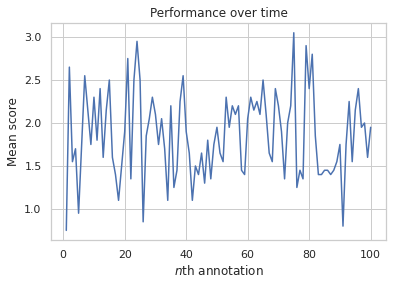

In [153]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

52
SpearmanrResult(correlation=0.1671272119482622, pvalue=0.24602496091725734)
(0.19040029224647148, 0.18535897514808322)


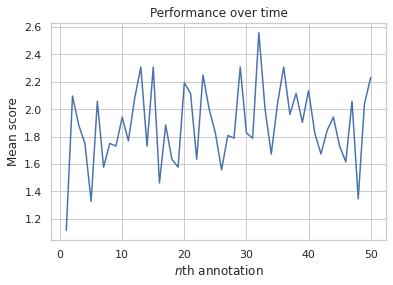

In [161]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

5
SpearmanrResult(correlation=0.027249697393282157, pvalue=0.7017015623061498)
(0.04170972496992613, 0.557591583014179)


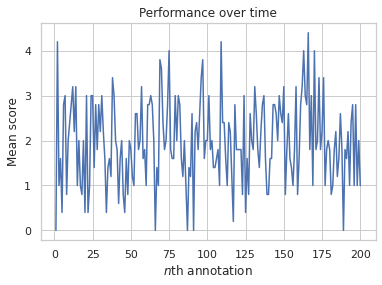

In [162]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

121
SpearmanrResult(correlation=0.5483233131440127, pvalue=3.518653774666208e-09)
(0.554434010647615, 2.166726919423323e-09)


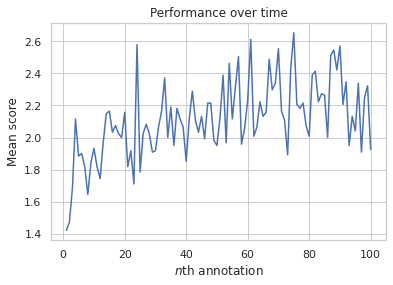

In [152]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

88
SpearmanrResult(correlation=0.3809113439518565, pvalue=2.631520312002652e-08)
(0.38199528109686837, 2.384724957238724e-08)


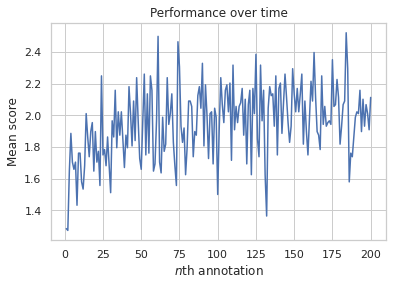

In [164]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

130
SpearmanrResult(correlation=0.5073006870593345, pvalue=0.00016992996859450018)
(0.5059809209922883, 0.0001778331409172452)


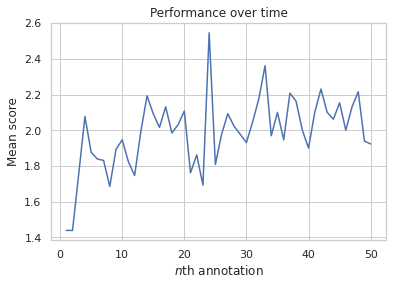

In [165]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
print(n)
data = np.array(s)
data = np.mean(data, axis=0)
print(stats.spearmanr(range(1,k+1), data))
print(stats.pearsonr(range(1,k+1), data))
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

### Inter-annotator agreement

For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [27]:
annotations_per_gen = annotation_df.groupby('generation')
# 
num_annotations_per_gen = annotations_per_gen.points.count()


In [28]:
def analyze_fraction_agreements():
  generation_ids = set(annotation_df["generation"].tolist())
  annotations_per_gen = annotation_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.boundary.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 13915 total annotations on generations with >1 annotation, 6275 were in agreement with another annotation on the true boundary position. That is 0.4509522098454905


In [29]:
user_df[user_df["pk"] == 2697]

,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined,groups,user_permissions,pk
2696,pbkdf2_sha256$180000$hp9YfmKe5tvv$eoUGPhGpjKz7...,2021-09-08T21:35:40.375Z,False,xyc,,,,False,True,2021-09-08T20:58:58.557Z,[],[],2697


## Profile Statistics

In [30]:
profile_df.is_temporary.mean()

0.8973373593192424